In [1]:
%load_ext autoreload
%autoreload 2

from cnn import CNN
from experiment import Experiment
from util import Util
from patch import Patch
from fixer import Fixer
from uglify import Uglify

from PIL import Image
import mahotas as mh
import numpy as np
import os
import cPickle as pickle
from string import Template
import shutil

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX TITAN (CNMeM is disabled, CuDNN 4007)
/home/d/nolearn/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
tifffile.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tifffile.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
with open('/home/d/dojo_xp/data/vi_s_new_cnn_large.p', 'rb') as f:
    vi_s30mins = pickle.load(f)

In [5]:
with open('/home/d/dojo_xp/data/fixes_new_cnn_large.p', 'rb') as f:
    fixes = pickle.load(f)

In [74]:
median_vis_30_mins = []
for vi in vi_s30mins:
    median_vis_30_mins.append(np.median(vi))

In [153]:
from collections import Counter
good_fixes_per_minute = []
bad_fixes_per_minute = []
good_encoded_fixes = []
bad_encoded_fixes = []
for f in range(len(fixes)):
    if fixes[f] == 'Good':
        good_encoded_fixes.append(1)
        bad_encoded_fixes.append(-1)
    elif fixes[f] == 'Bad':
        good_encoded_fixes.append(-1)
        bad_encoded_fixes.append(1)
    
for f in range(0,len(fixes),12):
    counts = Counter(fixes[f:f+12])
    good_counts = counts['Good']
    bad_counts = counts['Bad']
    good_fixes_per_minute.append(good_counts)
    bad_fixes_per_minute.append(bad_counts)

In [3]:
x_marks

NameError: name 'x_marks' is not defined

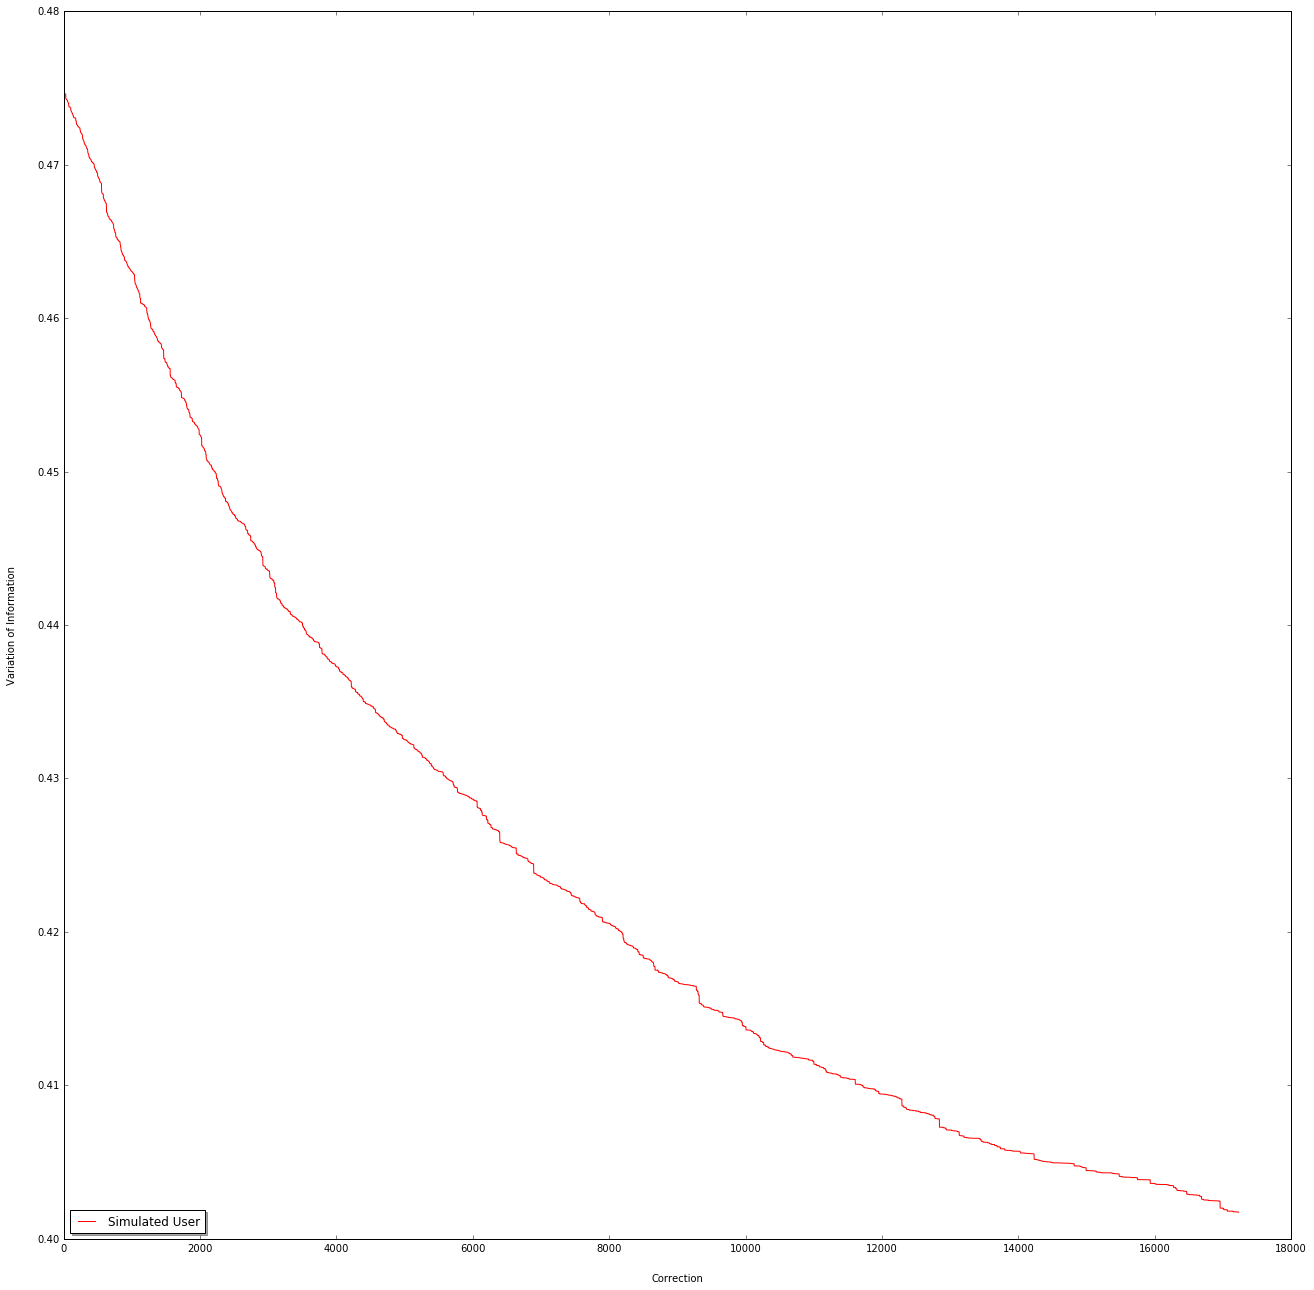

In [8]:
fig, ax = plt.subplots(figsize=(22,22))

x_marks = range(len(mean_vis_30_mins))
ax.plot(x_marks, mean_vis_30_mins, 'r', label='Simulated User')

# # fig, ax = plt.subplots()
# ax.plot(x_marks, old_vi_s, color='b', label='Automatic Corrections (Old CNN)')
# ax.plot(x_marks, new_vi_s, color='g', label='Automatic Corrections (New CNN)')
# ax.plot(x_marks, john_new_vi, color='r')
# ax.plot(x_marks, josh_new_vi, color='b')
plt.ylabel('Variation of Information', labelpad=20)

plt.xlabel('Correction', labelpad=20)

# ax.plot(x_marks, alyssa_new_vi, color='r')
legend = ax.legend(loc='lower left', shadow=True)

# plt.plot()
plt.show()

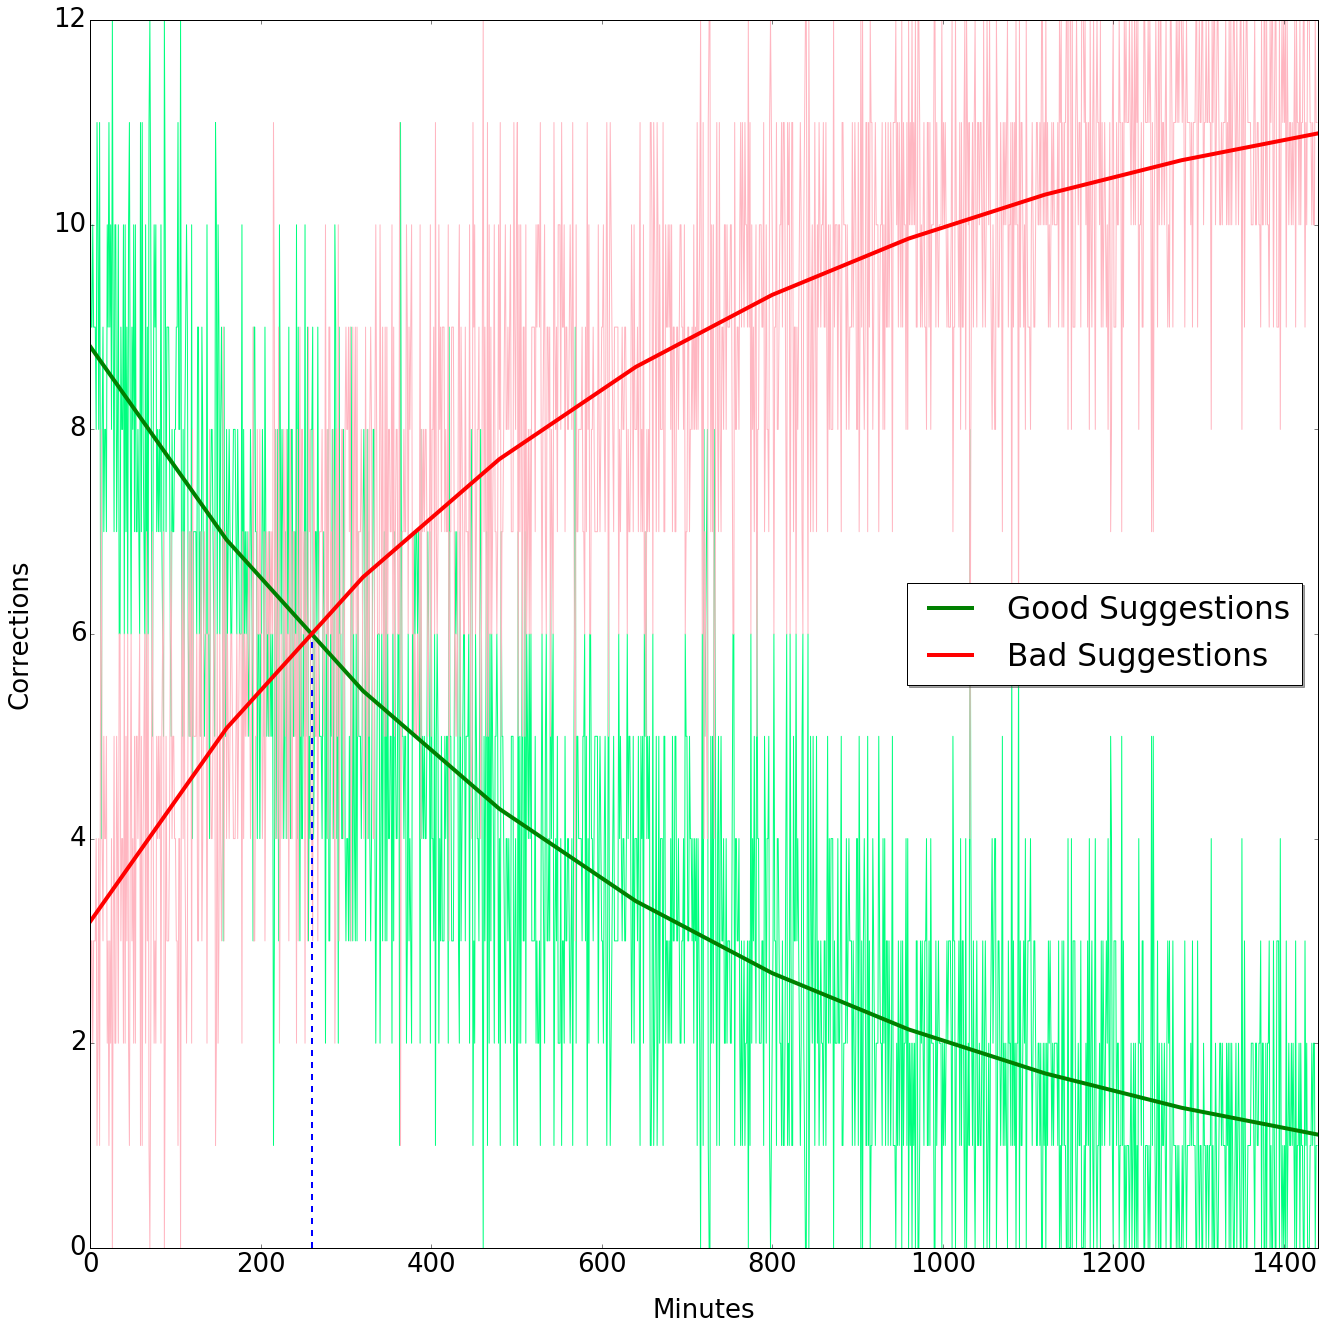

In [199]:
fig, ax = plt.subplots(figsize=(22,22))




x_marks = range(len(good_fixes_per_minute))

def green_func(x, a, b, c):
    return a*np.exp(-b*x)+c

def red_func(x, a, b, c):
    return 1-a*np.exp(-b*x)+c


popt, _ = curve_fit(green_func, x_marks, good_fixes_per_minute, p0=(1, 1e-6, 1))
goodx = np.linspace(0,len(good_fixes_per_minute),10)
goody = green_func(goodx, *popt)
popt2, _ = curve_fit(red_func, x_marks, bad_fixes_per_minute, p0=(1, 1e-6, 1))
bady = red_func(goodx, *popt2)


ax.plot(x_marks, good_fixes_per_minute, 'springgreen', linewidth=1)
ax.plot(x_marks, bad_fixes_per_minute ,'lightpink', linewidth=1)
ax.axvline(x=260, ymin=0, ymax=.5, color='b', linestyle='dashed', linewidth=2)
ax.plot(goodx, goody, 'g', linewidth=4, label='Good Suggestions')
ax.plot(goodx, bady, 'r', linewidth=4, label='Bad Suggestions')


# # fig, ax = plt.subplots()
# ax.plot(x_marks, old_vi_s, color='b', label='Automatic Corrections (Old CNN)')
# ax.plot(x_marks, new_vi_s, color='g', label='Automatic Corrections (New CNN)')
# ax.plot(x_marks, john_new_vi, color='r')
# ax.plot(x_marks, josh_new_vi, color='b')
plt.ylabel('Corrections', labelpad=20)

plt.xlabel('Minutes', labelpad=20)
plt.xlim([0,len(good_fixes_per_minute)])

# ax.plot(x_marks, alyssa_new_vi, color='r')
legend = ax.legend(loc='center right', shadow=True)

# plt.plot()
plt.show()

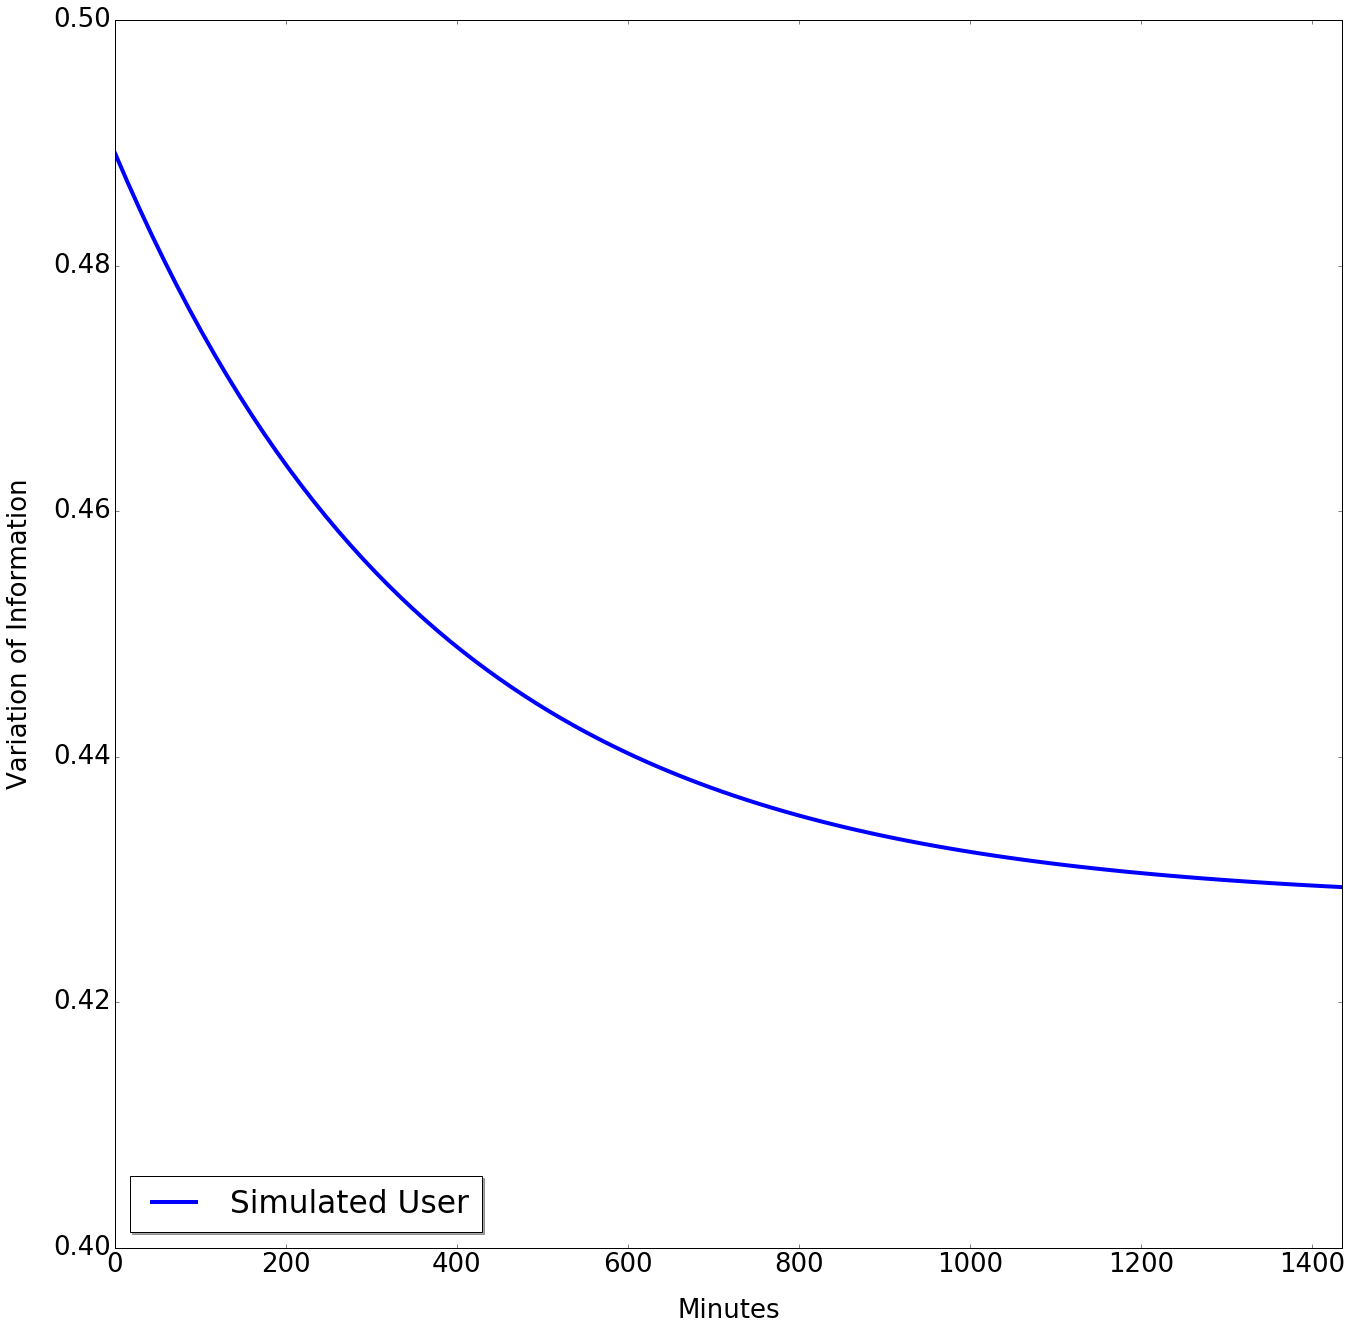

In [148]:
fig, ax = plt.subplots(figsize=(22,22))

x_marks = range(len(mean_vis_30_mins_per_min))

popt, _ = curve_fit(green_func, x_marks, median_vis_30_mins_per_min)#, p0=(1, 1e-6, 1))
popt2, _ = curve_fit(green_func, x_marks, min_vis_30_mins_per_min)#, p0=(1, 1e-6, 1))
popt3, _ = curve_fit(green_func, x_marks, max_vis_30_mins_per_min, p0=(1, 1e-6, 1))
xx = np.linspace(0,len(median_vis_30_mins_per_min),100)
mediany = green_func(xx, *popt)
miny = green_func(xx, *popt2)
maxy = green_func(xx, *popt3)

# ax.plot(x_marks, mean_vis_30_mins_per_min, 'r', label='Simulated User')
# ax.plot(x_marks, median_vis_30_mins_per_min, 'b', label='Simulated User')

# ax.plot(xx, miny, 'g', linewidth=1, label='Simulated User (Min)')
# ax.plot(xx, maxy, 'r', linewidth=1, label='Simulated User (Max)')
ax.plot(xx, mediany, linewidth=4, label='Simulated User')
# ax.plot(x_marks*12, median_vis_30_mins, 'o', linewidth=4, label='Simulated User (Median)')

# # fig, ax = plt.subplots()
# ax.plot(x_marks, old_vi_s, color='b', label='Automatic Corrections (Old CNN)')
# ax.plot(x_marks, new_vi_s, color='g', label='Automatic Corrections (New CNN)')
# ax.plot(x_marks, john_new_vi, color='r')
# ax.plot(x_marks, josh_new_vi, color='b')
plt.ylabel('Variation of Information', labelpad=20)

plt.xlabel('Minutes', labelpad=20)
plt.xlim([0,len(mean_vis_30_mins_per_min)])
plt.ylim([0.4,0.5])


# ax.plot(x_marks, alyssa_new_vi, color='r')
legend = ax.legend(loc='lower left', shadow=True)

font = {'family' : 'normal',
#         'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)

# plt.plot()
plt.show()

In [1]:
x_marks

NameError: name 'x_marks' is not defined

In [63]:
len(good_fixes_per_minute)

1440

In [108]:
median_vis_30_mins_per_min = []
min_vis_30_mins_per_min = []
std_vis_30_mins_per_min = []
max_vis_30_mins_per_min = []
j = 0
for i,vi in enumerate(median_vis_30_mins):
    if i % 12 == 0:
      median_per_min = np.median(median_vis_30_mins[j:j*12+12])
      min_per_min = np.min(median_vis_30_mins[j:j*12+12])
      max_per_min = np.max(median_vis_30_mins[j:j*12+12])  
      std_per_min = np.std(median_vis_30_mins[j:j*12+12])  
      median_vis_30_mins_per_min.append(median_per_min)
      min_vis_30_mins_per_min.append(min_per_min)
      max_vis_30_mins_per_min.append(max_per_min)
      std_vis_30_mins_per_min.append(std_per_min)
      j += 1
    

In [77]:
len(median_vis_30_mins_per_min)

1436

In [113]:
len(std_vis_30_mins_per_min)

1436

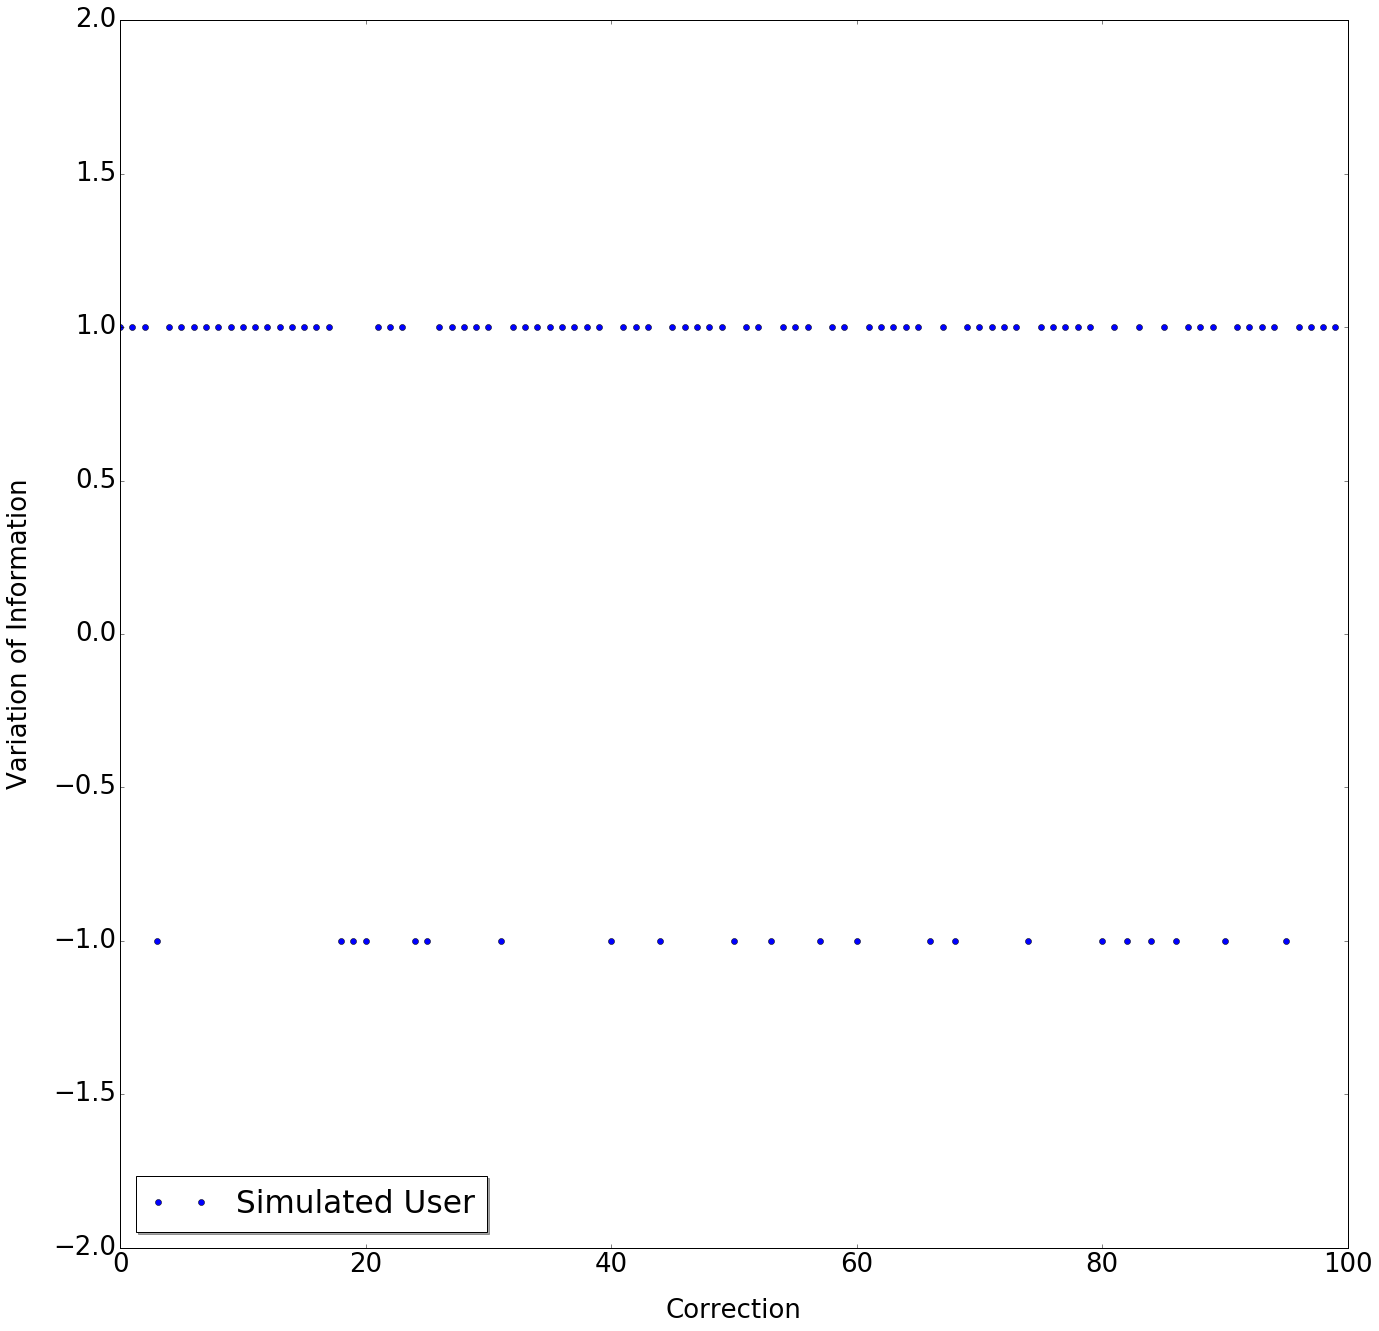

In [160]:
fig, ax = plt.subplots(figsize=(22,22))

x_marks = range(len(good_encoded_fixes[0:100]))
ax.plot(x_marks, good_encoded_fixes[0:100], 'o', label='Simulated User')
# ax.plot(x_marks, bad_encoded_fixes, 'r', label='Simulated User')

# # fig, ax = plt.subplots()
# ax.plot(x_marks, old_vi_s, color='b', label='Automatic Corrections (Old CNN)')
# ax.plot(x_marks, new_vi_s, color='g', label='Automatic Corrections (New CNN)')
# ax.plot(x_marks, john_new_vi, color='r')
# ax.plot(x_marks, josh_new_vi, color='b')
plt.ylabel('Variation of Information', labelpad=20)

plt.xlabel('Correction', labelpad=20)
plt.ylim(-2,2)
# ax.plot(x_marks, alyssa_new_vi, color='r')
legend = ax.legend(loc='lower left', shadow=True)

# plt.plot()
plt.show()

In [177]:
m = np.zeros((len(fixes),3), dtype=np.uint8)
for i,f in enumerate(fixes):
    if f == 'Good':
        m[i] = (0,255,0)
    else:
        m[i] = (255,0,0)


In [164]:
np.sqrt(m.shape)

array([ 131.4534138 ,    1.73205081])

In [194]:
m_new = m[0:130*130].reshape(130,130,3)

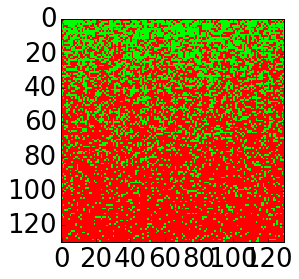

In [198]:
imshow(m_new, interpolation="nearest")

In [187]:
16900/50

338

In [2]:
fixes

NameError: name 'fixes' is not defined